In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D,Dropout,Flatten,Dense
import glob
from scipy import stats
import datetime as dt

# 8.1 DATA PREPARATION

## (a) Load and Prepare Data

In [118]:
ACC = pd.read_csv("acceleration.txt", sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv("heartrate.txt", sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv("labeled_sleep.txt", sep = ' ',names=['timedelta', 'sleep'])



In [119]:
# Check ‘timedelta’ max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()
HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()
SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()
print("ACC Start: %f End: %f " % (ACC_min_date,ACC_max_date))
print("HeartR Start: %f End: %f " % (HeartR_min_date,HeartR_max_date))
print("SleepL Start: %f End: %f " % (SleepL_min_date,SleepL_max_date))


ACC Start: -124489.161050 End: 17643.046417 
HeartR Start: -556410.360660 End: 16980.472290 
SleepL Start: 0.000000 End: 16980.000000 


In [120]:
# select only intersected timedelta (ACC, HeartR, SleepL) (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_new = ACC[(ACC["timedelta"]> ACC_min_date) & (ACC["timedelta"] < ACC_max_date) & (ACC["timedelta"]> HeartR_min_date) & (ACC["timedelta"] < HeartR_max_date) &(ACC["timedelta"]> SleepL_min_date) & (ACC["timedelta"] < SleepL_max_date)]
HeartR_new = HeartR[(HeartR["timedelta"]> ACC_min_date) & (HeartR["timedelta"] < ACC_max_date) & (HeartR["timedelta"]> HeartR_min_date) & (HeartR["timedelta"] < HeartR_max_date) &(HeartR["timedelta"]> SleepL_min_date) & (HeartR["timedelta"] < SleepL_max_date)]
SleepL_new = SleepL[(SleepL["timedelta"]> ACC_min_date) & (SleepL["timedelta"] < ACC_max_date) & (SleepL["timedelta"]> HeartR_min_date) & (SleepL["timedelta"] < HeartR_max_date) &(SleepL["timedelta"]> SleepL_min_date) & (SleepL["timedelta"] < SleepL_max_date)]
ACC_new

,timedelta,accX,accY,accZ
98777,0.000721,-0.234650,0.905975,0.362747
98778,0.017162,-0.231232,0.893265,0.371613
98779,0.037183,-0.227814,0.915848,0.369049
98780,0.057108,-0.240524,0.919159,0.352890
98781,0.076929,-0.240448,0.889175,0.350143
...,...,...,...,...
948796,16979.905934,-0.442413,-0.527573,0.723450
948797,16979.925889,-0.441925,-0.527573,0.721985
948798,16979.945849,-0.441437,-0.526108,0.721985
948799,16979.965927,-0.443405,-0.525116,0.723434


## (b) Load and Prepare Data (ACC)

In [121]:
# Convert to datetime and round to second using an ACC as the value as the *** as units.
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], 's').round('1s'))

 # Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean()
ACC_new2 = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1).reset_index()
ACC_new2

C:\Users\Cherry Labtop\AppData\Local\Temp\ipykernel_23728\2589896904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], 's').round('1s'))


,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


In [122]:
# 1 2 3 -> 1-1 2-1 3-1  -> 0 1 2 

# ACC_new2['timedelta'] = ACC_new2['timedelta'] - ACC_new2['timedelta'].min() 
ACC_new2

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


# (c) Load and Prepare Data (Heart rate)

In [123]:
# ------------ Rounding Heart Rate (Rounding to 1 sec) -------------------------------
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],'s').round('1s'))
# HeartR_new['timedelta'] = HeartR_new['timedelta'] - HeartR_new['timedelta'].min() 
HeartR_new

C:\Users\Cherry Labtop\AppData\Local\Temp\ipykernel_23728\1135719712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],'s').round('1s'))


,timedelta,heartrate
1576,0 days 00:00:08,97
1577,0 days 00:00:13,95
1578,0 days 00:00:18,96
1579,0 days 00:00:19,95
1580,0 days 00:00:24,95
...,...,...
4872,0 days 04:42:34,73
4873,0 days 04:42:39,72
4874,0 days 04:42:44,74
4875,0 days 04:42:50,75


In [124]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new2

,heartrate
timedelta,
0 days 00:00:08,97.0
0 days 00:00:09,97.0
0 days 00:00:10,97.0
0 days 00:00:11,97.0
0 days 00:00:12,97.0
...,...
0 days 04:42:51,75.0
0 days 04:42:52,75.0
0 days 04:42:53,75.0


In [125]:
# ------------ Rounding Sleep Label (Rounding to 1 sec) -------------------------------
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],'s').round('1s'))
# SleepL_new['timedelta'] = SleepL_new['timedelta'] - SleepL_new['timedelta'].min() 

C:\Users\Cherry Labtop\AppData\Local\Temp\ipykernel_23728\512641816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],'s').round('1s'))


In [126]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2

,sleep
timedelta,
0 days 00:00:30,-1.0
0 days 00:00:31,-1.0
0 days 00:00:32,-1.0
0 days 00:00:33,-1.0
0 days 00:00:34,-1.0
...,...
0 days 04:42:26,0.0
0 days 04:42:27,0.0
0 days 04:42:28,0.0


# (e) Merge Data and Standardized data

In [127]:
# ------------Merge All Data -------------------------------
df = []
df = pd.merge_asof(ACC_new2, HeartR_new2, on='timedelta')
df = pd.merge_asof(df, SleepL_new2, on ='timedelta')
df

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:00:00,-0.243203,0.895372,0.367591,NaN,NaN
1,0 days 00:00:01,-0.240757,0.873826,0.415446,NaN,NaN
2,0 days 00:00:02,-0.244620,0.883943,0.387026,NaN,NaN
3,0 days 00:00:03,-0.248036,0.902427,0.347812,NaN,NaN
4,0 days 00:00:04,-0.241778,0.912946,0.321502,NaN,NaN
...,...,...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950,76.0,0.0
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410,76.0,0.0
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003,76.0,0.0
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265,76.0,0.0


In [128]:
df['sleep'] = df['sleep'].replace(-1,0)

In [129]:
# Fill NA
df['heartrate'] = df['heartrate'].fillna(df['heartrate'].median())
df['sleep'] = df['sleep'].fillna(0)

df

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:00:00,-0.243203,0.895372,0.367591,82.0,0.0
1,0 days 00:00:01,-0.240757,0.873826,0.415446,82.0,0.0
2,0 days 00:00:02,-0.244620,0.883943,0.387026,82.0,0.0
3,0 days 00:00:03,-0.248036,0.902427,0.347812,82.0,0.0
4,0 days 00:00:04,-0.241778,0.912946,0.321502,82.0,0.0
...,...,...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950,76.0,0.0
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410,76.0,0.0
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003,76.0,0.0
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265,76.0,0.0


In [130]:
df.drop(['timedelta'],axis=1)

,accX,accY,accZ,heartrate,sleep
0,-0.243203,0.895372,0.367591,82.0,0.0
1,-0.240757,0.873826,0.415446,82.0,0.0
2,-0.244620,0.883943,0.387026,82.0,0.0
3,-0.248036,0.902427,0.347812,82.0,0.0
4,-0.241778,0.912946,0.321502,82.0,0.0
...,...,...,...,...,...
16976,-0.442763,-0.525892,0.722950,76.0,0.0
16977,-0.441990,-0.525476,0.723410,76.0,0.0
16978,-0.441581,-0.525116,0.724003,76.0,0.0
16979,-0.442283,-0.525849,0.723265,76.0,0.0


In [131]:
# Standardized data
scaler = preprocessing.StandardScaler()
feature_columns = df[['accX', 'accY', 'accZ', 'heartrate']]
label_columns = df[['sleep']]
df_feature = pd.DataFrame(scaler.fit_transform(feature_columns.values),index = feature_columns.index,columns=feature_columns.columns)
df_feature

,accX,accY,accZ,heartrate
0,-0.587547,3.058075,0.698728,0.143539
1,-0.581456,2.995094,0.757746,0.143539
2,-0.591075,3.024668,0.722696,0.143539
3,-0.599581,3.078699,0.674335,0.143539
4,-0.583998,3.109450,0.641889,0.143539
...,...,...,...,...
16976,-1.084456,-1.096565,1.136974,-0.630455
16977,-1.082531,-1.095348,1.137542,-0.630455
16978,-1.081511,-1.094296,1.138273,-0.630455
16979,-1.083260,-1.096440,1.137363,-0.630455


<AxesSubplot:>

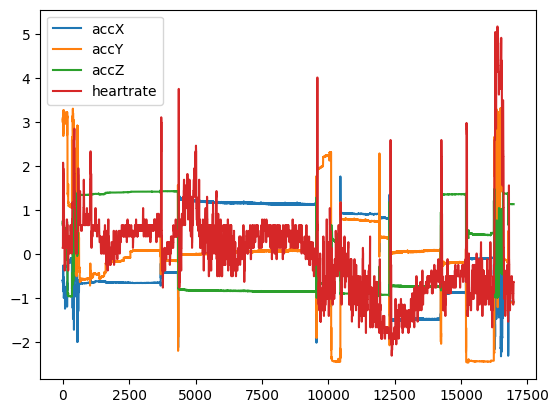

In [132]:
df_feature.plot()


In [133]:
df_label =label_columns

<AxesSubplot:>

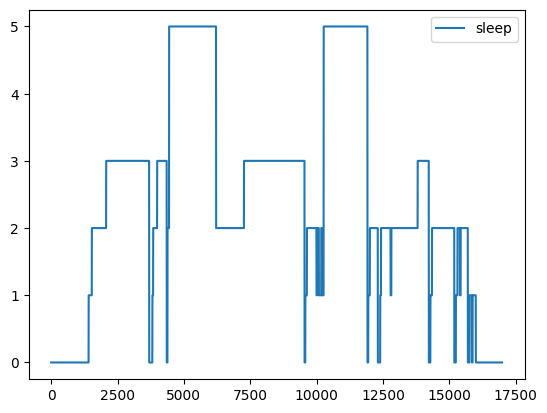

In [134]:
df_label.plot()

## 9.2.1 Create 3d input

In [135]:
slidingW = 100
Stride_step = 5
n_features = 4 
df_feature3D = np.array([],ndmin=2)
df_label_new = np.array([])

for t in range(0 , len(df_feature), Stride_step ):
    F3d = np.array(df_feature[t:t+slidingW],ndmin=2)
    if len(F3d) <slidingW:
        break
    F3d.reshape(slidingW, n_features,1)
    if df_feature3D.size == 0 :
        df_feature3D = F3d
    else:
        df_feature3D = np.dstack((df_feature3D,F3d))
    Labels = stats.mode(df_label[t : t+slidingW])
    df_label_new = np.append(df_label_new,Labels[0])

C:\Users\Cherry Labtop\AppData\Local\Temp\ipykernel_23728\3739933216.py:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  Labels = stats.mode(df_label[t : t+slidingW])


In [136]:
F3d

array([[-1.08121498, -1.09911905,  1.13700377, -0.63045529],
       [-1.08093764, -1.09792365,  1.13793902, -0.63045529],
       [-1.08281078, -1.09874351,  1.13714151, -0.63045529],
       [-1.08311172, -1.09805034,  1.13739179, -0.63045529],
       [-1.08034736, -1.09649515,  1.13830561, -0.50145623],
       [-1.0826026 , -1.09738127,  1.13779902, -0.50145623],
       [-1.08299014, -1.09776666,  1.13724688, -0.50145623],
       [-1.08209192, -1.09651416,  1.13801504, -0.50145623],
       [-1.08216258, -1.09677464,  1.13791832, -0.50145623],
       [-1.08243994, -1.09797627,  1.13671885, -0.50145623],
       [-1.08195894, -1.09773187,  1.13735717, -0.50145623],
       [-1.08120816, -1.09632232,  1.13772863, -0.50145623],
       [-1.08298403, -1.09747939,  1.13714866, -0.50145623],
       [-1.08249694, -1.09793615,  1.13722506, -0.50145623],
       [-1.08089054, -1.09637587,  1.1378852 , -0.50145623],
       [-1.07959642, -1.0963384 ,  1.13828791, -0.50145623],
       [-1.0811109 , -1.

## 9.1.2 Train Test Split

In [137]:
# ------------ Train-Test-Split 2D features -------------------------------
seed = 42
x_train, x_test, y_train, y_test = model_selection.train_test_split( df_feature, df_label, test_size=0.3, random_state=seed)

In [138]:
df_feature3D = np.swapaxes(df_feature3D,0,2)
df_feature3D = np.swapaxes(df_feature3D,1,2)
df_feature3D = df_feature3D[..., np.newaxis]

In [139]:
df_feature3D


array([[[[-0.58754699],
         [ 3.05807519],
         [ 0.69872824],
         [ 0.14353909]],

        [[-0.58145574],
         [ 2.99509378],
         [ 0.75774575],
         [ 0.14353909]],

        [[-0.59107524],
         [ 3.02466836],
         [ 0.72269623],
         [ 0.14353909]],

        ...,

        [[-0.92104538],
         [ 3.14574551],
         [ 0.23209668],
         [ 0.40153722]],

        [[-0.91866235],
         [ 3.14714076],
         [ 0.23126907],
         [ 0.40153722]],

        [[-0.90930807],
         [ 3.15256736],
         [ 0.23283358],
         [ 0.14353909]]],


       [[[-0.63079638],
         [ 3.06967162],
         [ 0.66802186],
         [ 0.14353909]],

        [[-0.65623081],
         [ 3.03358303],
         [ 0.6929944 ],
         [ 0.14353909]],

        [[-0.61745949],
         [ 3.04996268],
         [ 0.70392346],
         [ 0.14353909]],

        ...,

        [[-0.92642696],
         [ 3.14347961],
         [ 0.2498879 ],
         [ 0.272

In [140]:
df_label_new

array([0., 0., 0., ..., 0., 0., 0.])

In [141]:
x_train, x_test, y_train, y_test = model_selection.train_test_split( df_feature, df_label, test_size = 0.3, random_state = 42)

In [142]:

x3D_train, x3D_test, y3D_train, y3D_test = model_selection.train_test_split( df_feature3D , df_label_new,test_size = 0.33 ,random_state=2)

## 9.2.1 NN Model Train Test

In [143]:
Hidden_Layer_param = (30, 30, 30)
mlp = MLPClassifier(hidden_layer_sizes = Hidden_Layer_param)

In [144]:
mlp

MLPClassifier(hidden_layer_sizes=(30, 30, 30))

In [145]:
mlp.fit(x_train,y_train)
smlp_pred = mlp.predict(x_test)

c:\Users\Cherry Labtop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Cherry Labtop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [146]:
y_test

,sleep
13205,2.0
6393,2.0
608,0.0
4745,5.0
12036,2.0
...,...
5148,5.0
1369,0.0
740,0.0
5527,5.0


In [147]:
smlp_pred[0]

2.0

In [148]:
print('Confusion Matrix of smlp_pred: ')
print(confusion_matrix(y_test, smlp_pred))
print('Classification Report of smlp_preds: ')
print(classification_report(y_test, smlp_pred))

Confusion Matrix of smlp_pred: 
[[ 810   13   19    9    2]
 [  78  124   60    3   13]
 [ 123   17 1215   77   56]
 [   8    0   51 1398    0]
 [   0    0   18    0 1001]]
Classification Report of smlp_preds: 
              precision    recall  f1-score   support

         0.0       0.79      0.95      0.87       853
         1.0       0.81      0.45      0.57       278
         2.0       0.89      0.82      0.85      1488
         3.0       0.94      0.96      0.95      1457
         5.0       0.93      0.98      0.96      1019

    accuracy                           0.89      5095
   macro avg       0.87      0.83      0.84      5095
weighted avg       0.89      0.89      0.89      5095



## 9.3.1 CNN Model Train Test

In [149]:
# ------------ CNN Architecture parameter -------------------------------
# Nlayer (CNN, dense), Nnode, Activation
CNN_L1 = 16
CNN_L2 = 64
CNN_L3 = 128
D_L1 = 512
D_out = 6
n_feature = 4
Act_func = "relu"
Ker_size = (3,3)
Pooling_size = (2,1)
Input_shape = (slidingW, n_feature, 1)

In [150]:
# ------------ Create CNN Model -------------------------------
model = models.Sequential()
model.add(layers.Conv2D(CNN_L1, kernel_size=Ker_size, activation=Act_func,input_shape=Input_shape,padding='same'))
model.add(layers.MaxPooling2D(pool_size=Pooling_size))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(CNN_L2, kernel_size=Ker_size, activation= Act_func, padding='same'))
model.add(layers.MaxPooling2D(pool_size= Pooling_size))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(CNN_L3, kernel_size=Ker_size, activation= Act_func,padding='same'))
model.add(layers.MaxPooling2D(pool_size= Pooling_size))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(D_L1 , activation= Act_func ))
model.add(layers.Dense(D_out, activation='sigmoid'))
model.compile(optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 4, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 4, 16)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 50, 4, 16)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 4, 64)         9280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 4, 64)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 25, 4, 64)        

In [151]:
# ------------ Create Optimizer -------------------------------

model.compile(optimizer='adam',loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["acc"])

In [152]:
# ------ Train CNN using 3D feature--------------------------------------------
history = model.fit(x3D_train, y3D_train, epochs=50, batch_size=64,validation_data=(x3D_test, y3D_test))

Epoch 1/50


c:\Users\Cherry Labtop\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 3s 59ms/step - loss: 1.1115 - acc: 0.5314 - val_loss: 0.7463 - val_acc: 0.6942
Epoch 2/50
36/36 [==============================] - 2s 55ms/step - loss: 0.6365 - acc: 0.7100 - val_loss: 0.5877 - val_acc: 0.7713
Epoch 3/50
36/36 [==============================] - 2s 52ms/step - loss: 0.5294 - acc: 0.7741 - val_loss: 0.5185 - val_acc: 0.8108
Epoch 4/50
36/36 [==============================] - 2s 54ms/step - loss: 0.4684 - acc: 0.8068 - val_loss: 0.4270 - val_acc: 0.8520
Epoch 5/50
36/36 [==============================] - 2s 52ms/step - loss: 0.4253 - acc: 0.8121 - val_loss: 0.4021 - val_acc: 0.8583
Epoch 6/50
36/36 [==============================] - 2s 51ms/step - loss: 0.4076 - acc: 0.8271 - val_loss: 0.4217 - val_acc: 0.8179
Epoch 7/50
36/36 [==============================] - 2s 53ms/step - loss: 0.3930 - acc: 0.8391 - val_loss: 0.3912 - val_acc: 0.8619
Epoch 8/50
36/36 [==============================] - 2s 57ms/step - loss: 0.3638 - acc: 0.8466 

In [153]:
CNN_pred = model.predict(x3D_test)

35/35 [==============================] - 0s 7ms/step


In [154]:
CNN_pred[0]

array([9.9374861e-01, 7.2961732e-12, 9.6454310e-01, 1.0000000e+00,
       2.1172677e-06, 4.5391999e-11], dtype=float32)

In [155]:
y3D_test[0]

3.0

In [156]:
print('Confusion Matrix of smlp_pred: ')
print(confusion_matrix(y3D_test, CNN_pred))
print('Classification Report of smlp_preds: ')
print(classification_report(y3D_test, CNN_pred))

Confusion Matrix of smlp_pred: 


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets